Begun 2/10/2025

Analysis of same nine maps as nb01, but after fixing the covariance for TT calibration likelihood to use the right w2w4 factors and to add y to the covariance. The ell range here is 1000-2000 in bins of 200.

Results in angle_calc_1739229378

In [1]:
import numpy as np
from pixell import enmap, enplot, bunch
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import scipy
from scipy import optimize as op
from scipy.stats.distributions import chi2

In [2]:
# Loading spectra from run
spectra_dict = np.load('/home/zbh5/act_analysis/act_axion_analysis/results/angle_calc_1739229378/angle_calc_1739229378_spectra.npy',allow_pickle=True).item()

In [3]:
maps = np.array(list(spectra_dict.keys()))
print(maps)
n_maps = len(maps)
print(n_maps)
print(spectra_dict[maps[0]].keys())

['depth1_1494735603_pa4_f150_map.fits'
 'depth1_1494735603_pa5_f150_map.fits'
 'depth1_1494735603_pa6_f150_map.fits'
 'depth1_1494743515_pa4_f150_map.fits'
 'depth1_1494743515_pa5_f150_map.fits'
 'depth1_1494743515_pa6_f150_map.fits'
 'depth1_1494761700_pa4_f150_map.fits'
 'depth1_1494761700_pa5_f150_map.fits'
 'depth1_1494761700_pa6_f150_map.fits']
9
dict_keys(['ell', 'E1xB2', 'E2xB1', 'E1xE1', 'B2xB2', 'E2xE2', 'B1xB1', 'E1xE2', 'B1xB2', 'E1xB1', 'E2xB2', 'bincount', 'estimator', 'covariance', 'CAMB_EE', 'CAMB_BB', 'w2_depth1', 'w2_cross', 'w2_ref', 'fsky', 'w2w4_depth1', 'w2w4_cross', 'w2w4_ref', 'meas_angle', 'meas_errbar', 'initial_timestamp', 'median_timestamp', 'ivar_sum', 'residual_mean', 'residual_sum', 'map_cut', 'T1xcal1T', 'cal1Txcal2T', 'cal1Txcal1T', 'cal2Txcal2T', 'T1xT1', 'T1xcal2T', 'cal_factor', 'cal_factor_errbar', 'w2_depth1xcal1', 'w2_depth1xcal2', 'w2_cal1xcal2', 'w2_cal1xcal1', 'w2_cal2xcal2', 'w2w4_all_three', 'w2w4_depth1xcal1', 'w2w4_cal1xcal2'])


In [8]:
cut_flags = np.zeros(n_maps)
cal_factors = np.zeros(n_maps)
cal_factor_errbars = np.zeros(n_maps)
all_w2w4_all_three = np.zeros(n_maps)
all_w2w4_depth1xcal1 = np.zeros(n_maps)
all_w2w4_cal1xcal2 = np.zeros(n_maps)
for i in range(n_maps):
    cut_flags[i] = spectra_dict[maps[i]]['map_cut']
    cal_factors[i] = spectra_dict[maps[i]]['cal_factor']
    cal_factor_errbars[i] = spectra_dict[maps[i]]['cal_factor_errbar']
    all_w2w4_all_three[i] = spectra_dict[maps[i]]['w2w4_all_three']
    all_w2w4_depth1xcal1[i] = spectra_dict[maps[i]]['w2w4_depth1xcal1']
    all_w2w4_cal1xcal2[i] = spectra_dict[maps[i]]['w2w4_cal1xcal2']
    
# Extracting map info and results into separate arrays for ease of access
# Not using numpy arrays at first to more easily put strings and arrays in the list
map_arrays = []
map_timestamps = []
all_cal1xcal2 = []
all_cal1xdepth1 = []
all_cal1xcal1 = []
all_depth1xdepth1 = []
all_cal2xdepth1 = []
all_cal2xcal2 = []
all_bincounts = []

for i in range(n_maps):
    map_arrays.append(maps[i].split('_')[2])
    map_timestamps.append(maps[i].split('_')[1])
    all_cal1xcal2.append(spectra_dict[maps[i]]['cal1Txcal2T'])
    all_cal1xdepth1.append(spectra_dict[maps[i]]['T1xcal1T'])
    all_cal1xcal1.append(spectra_dict[maps[i]]['cal1Txcal1T'])
    all_depth1xdepth1.append(spectra_dict[maps[i]]['T1xT1'])
    all_cal2xdepth1.append(spectra_dict[maps[i]]['T1xcal2T'])
    all_cal2xcal2.append(spectra_dict[maps[i]]['cal2Txcal2T'])
    all_bincounts.append(spectra_dict[maps[i]]['bincount'])
map_arrays = np.array(map_arrays)
map_timestamps = np.array(map_timestamps)
all_cal1xcal2 = np.array(all_cal1xcal2)
all_cal1xdepth1 = np.array(all_cal1xdepth1)
all_cal1xcal1 = np.array(all_cal1xcal1)
all_depth1xdepth1 = np.array(all_depth1xdepth1)
all_cal2xdepth1 = np.array(all_cal2xdepth1)
all_cal2xcal2 = np.array(all_cal2xcal2)
all_bincounts = np.array(all_bincounts)

In [12]:
def cal_likelihood(y, cal1xcal2, cal1xdepth1, cal1xcal1, cal2xcal2, cal2xdepth1, depth1xdepth1,
                   nu_cal1_cal2, nu_cal1_depth1, nu_all_three):
    """
        Calculates the likelihood for TT calibration for an input
        value of the calibration factor, y.

        estimator = TT_cal1xcal2 - y*TT_cal1xdepth1

        The covariance has different mode count factors for each of the
        three covariance terms that are summed to get the full covariance.
        The y factor also multiplies the TT spectrum for cal1xdepth1 
        wherever it appears in the covariance to account for how the
        changing calibration factor affects the covariance.
    """
    numerator = (cal1xcal2 - y*cal1xdepth1)**2
    covariance = ((1/nu_cal1_cal2)*(cal1xcal1*cal2xcal2+cal1xcal2**2)
                 +(1/nu_cal1_depth1)*(depth1xdepth1*cal1xcal1+y**2*cal1xdepth1**2)
               -2*(1/nu_all_three)*(y*cal1xdepth1*cal1xcal2+cal1xcal1*cal2xdepth1))
    denominator = 2*covariance
    likelihood = np.exp(-np.sum(numerator/denominator))
    return likelihood

def gaussian(x,mean,sigma):
    """Normalized Gaussian for curve_fit"""
    amp = 1.0
    return amp*np.exp(-(x-mean)**2/(2*sigma**2))

def gaussian_fit_curvefit(angles,data,guess=[1.0*np.pi/180.0, 5.0*np.pi/180.0]):
    """
        Uses scipy.optimize.curve_fit() to fit a Gaussian to the likelihood to
        get the mean and standard deviation.

        Assumes everything is in radians when fitting angles.

        The default guess (mean 1 deg, std dev 5 deg) here is for the angle likelihood. 
        When using this function to fit the TT calibration likelihood, pass in a different guess.
    """
    popt, pcov = op.curve_fit(gaussian,angles,data,guess,maxfev=50000)
    mean = popt[0]
    std_dev = np.abs(popt[1])
    return mean, std_dev

def gaussian_fit_moment(angles,data):
    """
       Uses moments to quickly find mean and standard deviation of a Gaussian
       for the likelihood.

       Assumes everything is in radians when fitting angles.
    """
    mean = np.sum(angles*data)/np.sum(data)
    std_dev = np.sqrt(abs(np.sum((angles-mean)**2*data)/np.sum(data)))
    return mean, std_dev

def cal_sample_likelihood_and_fit(cal1xcal2, cal1xdepth1, cal1xcal1, cal2xcal2, cal2xdepth1, 
                                  depth1xdepth1, nu_cal1_cal2, nu_cal1_depth1, nu_all_three, 
                                  y_min=0.7, y_max=1.3, num_pts=50000, use_curvefit=True,plot=True,map_fname=None):
    """
        Samples the likelihood for the TT calibration at num_pts values of the calibration
        factor, y, between the values y_min and y_max.
    """
    if(y_min >= y_max): 
        raise ValueError("The min y value must be smaller than the max!")
    y_values = np.linspace(y_min,y_max,num=num_pts)

    cal_sampled_likelihood = [cal_likelihood(y, cal1xcal2, cal1xdepth1, cal1xcal1, 
                                             cal2xcal2, cal2xdepth1, depth1xdepth1,
                                             nu_cal1_cal2, nu_cal1_depth1, nu_all_three) for y in y_values]
    norm_sampled_likelihood = cal_sampled_likelihood/np.max(cal_sampled_likelihood)

    if use_curvefit:
        # The default guess starting values are for the angle likelihood, so pass new ones here
        guess = [1.0, 0.2] # Guessing a center value of 1.0 with std dev 0.2
        fit_values = gaussian_fit_curvefit(y_values,norm_sampled_likelihood, guess=guess)
    else:
        fit_values = gaussian_fit_moment(y_values,norm_sampled_likelihood)

    if plot:
        map_name = os.path.split(map_fname)[1][:-9] # removing "_map.fits"
        mean = fit_values[0]
        stddev = fit_values[1]
        fig = plt.figure(figsize=(6.4,4.8), layout='constrained')
        plt.plot(y_values,norm_sampled_likelihood,'b.',label='Mean={:1.3f}\n$\sigma$={:1.3f}'.format(mean,stddev))
        plt.axvline(mean,alpha=0.5,color='black')
        plt.plot(y_values, gaussian(y_values,mean,stddev), 'r', label='Fit Gaussian')
        plt.legend()
        plt.ylabel("Likelihood")
        plt.xlabel("Calibration factor (unitless)")
        plt.grid()
        plt.title("TT Cal Likelihood " + map_name)
        plt.show()
        plt.close()
        
    return fit_values

def get_tfunc(kx, ky, bins, lmax=5000):
    """Calculating transfer function for filtering with cutoffs kx and ky.
       lmax just needs to be higher than the range we want to measure since
       the bins will appropriately handle excluding higher ells."""
    cut = (ky+kx)*4
    ell = np.arange(lmax)
    tfunc = np.zeros(lmax)
    tfunc[1:] = 1 - cut / (2*np.pi*ell[1:])

    digitized = np.digitize(ell, bins, right=True)
    bincount = np.bincount(digitized)[1:-1]
    tfunc_binned = np.bincount(digitized, tfunc.reshape(-1))[1:-1]/bincount
    return tfunc_binned

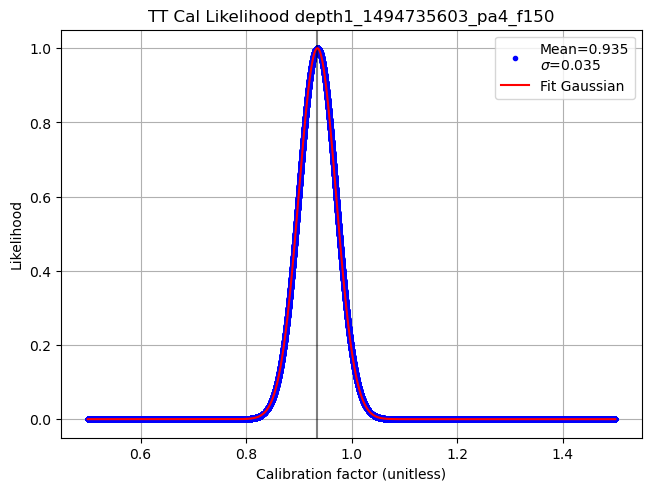

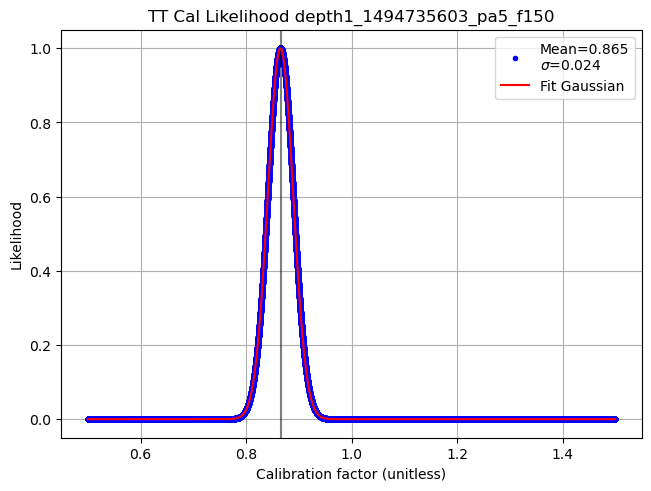

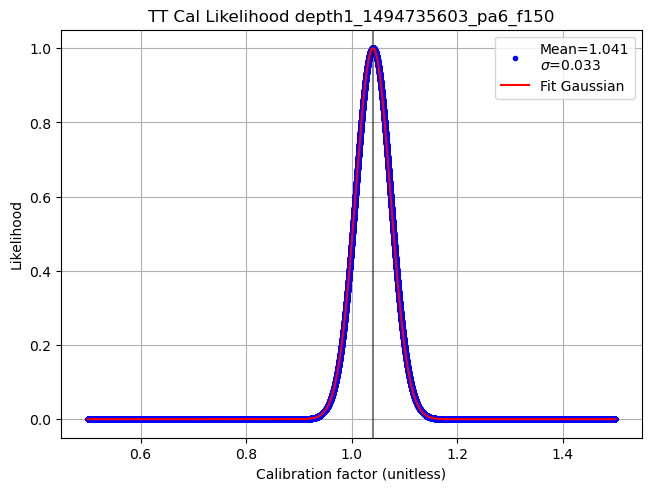

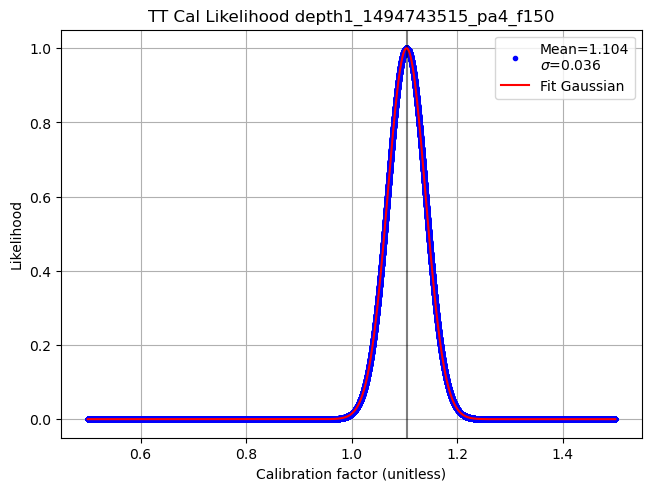

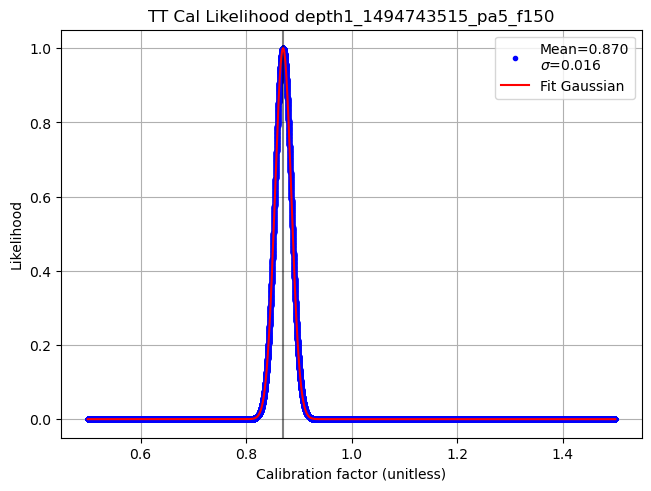

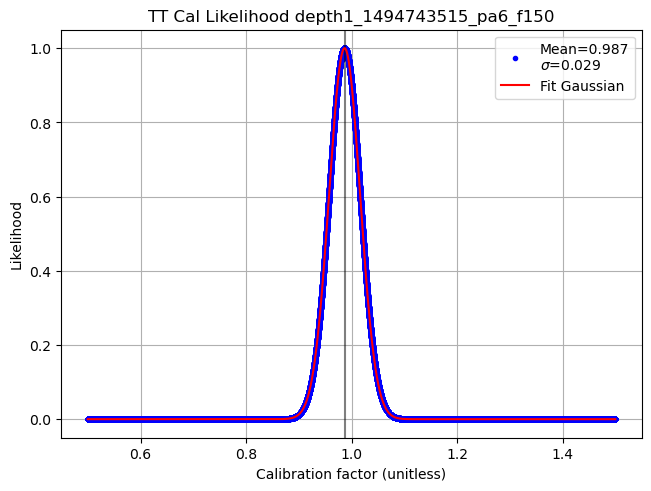

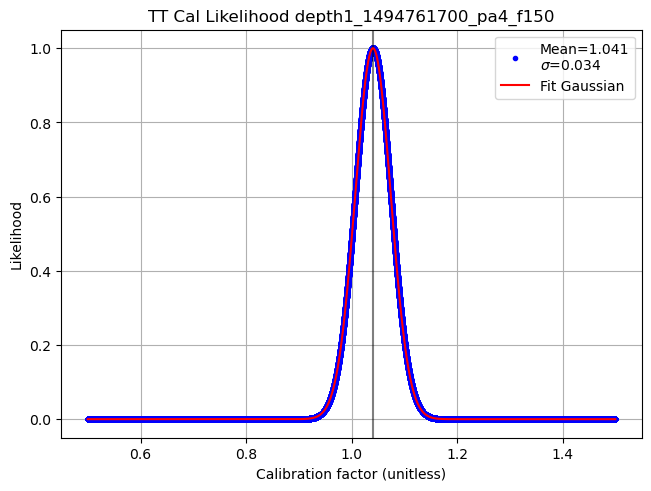

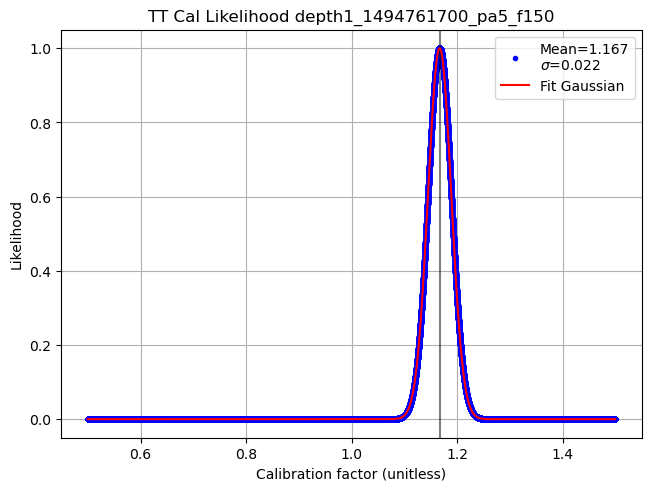

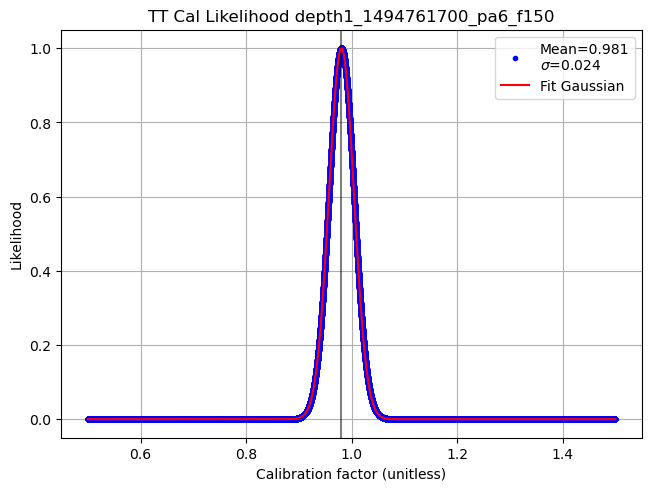

In [13]:
num_pts = 50000
y_min = 0.5
y_max = 1.5

lmin = 1000
lmax = 2001
bin_size = 200
bins = np.arange(lmin, lmax, bin_size)
centers = (bins[1:] + bins[:-1])/2.0

tfunc = get_tfunc(90,50,bins)

all_fit_values = np.zeros(n_maps)
all_fit_errbars = np.zeros(n_maps)

for i in range(n_maps):
    cal_binned_nu_cal1_cal2 = all_bincounts[i]*all_w2w4_cal1xcal2[i]*np.sqrt(tfunc)
    cal_binned_nu_cal1_depth1 = all_bincounts[i]*all_w2w4_depth1xcal1[i]*np.sqrt(tfunc)
    cal_binned_nu_all_three = all_bincounts[i]*all_w2w4_all_three[i]*np.sqrt(tfunc)
    
    cal_fit_values = cal_sample_likelihood_and_fit(all_cal1xcal2[i], all_cal1xdepth1[i], all_cal1xcal1[i],
                                                   all_cal2xcal2[i], all_cal2xdepth1[i], all_depth1xdepth1[i],
                                                   cal_binned_nu_cal1_cal2, cal_binned_nu_cal1_depth1, cal_binned_nu_all_three,
                                                   y_min=y_min,y_max=y_max,num_pts=num_pts,use_curvefit=False,
                                                   plot=True,map_fname=maps[i])
    
    all_fit_values[i] = cal_fit_values[0]
    all_fit_errbars[i] = cal_fit_values[1]

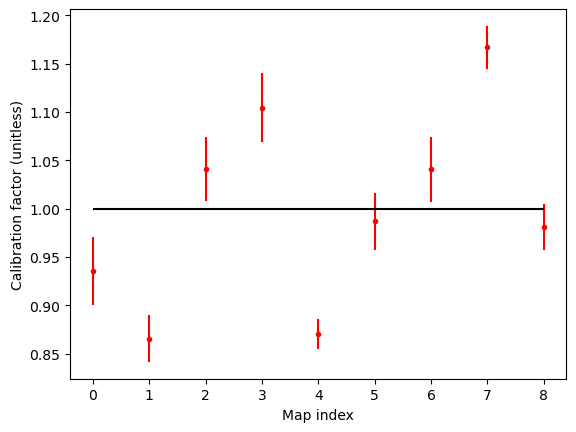

In [14]:
plt.errorbar(range(n_maps),all_fit_values,yerr=all_fit_errbars,fmt='r.')
plt.hlines(1.0,0.0,n_maps-1,'black')
plt.ylabel('Calibration factor (unitless)')
plt.xlabel('Map index')
plt.show()
plt.close()

In [15]:
# Checking chi2 for the model fit of estimator-theory
# Not sure how to account for errorbar on y in the covariance yet
chi2_good_maps = []
pte_good_maps = []

for i in range(n_maps):
    null = all_cal1xcal2[i] - all_fit_values[i]*all_cal1xdepth1[i]
    cal_binned_nu_cal1_cal2 = all_bincounts[i]*all_w2w4_cal1xcal2[i]*np.sqrt(tfunc)
    cal_binned_nu_cal1_depth1 = all_bincounts[i]*all_w2w4_depth1xcal1[i]*np.sqrt(tfunc)
    cal_binned_nu_all_three = all_bincounts[i]*all_w2w4_all_three[i]*np.sqrt(tfunc)
    sum_cov = ((1/cal_binned_nu_cal1_cal2)*(all_cal1xcal1[i] * all_cal2xcal2[i] + all_cal1xcal2[i]**2)
                 +(1/cal_binned_nu_cal1_depth1)*(all_depth1xdepth1[i] * all_cal1xcal1[i] + all_fit_values[i]**2*all_cal1xdepth1[i]**2)
               -2*(1/cal_binned_nu_all_three)*(all_fit_values[i]*all_cal1xdepth1[i] * all_cal1xcal2[i] + 
                                    all_cal1xcal1[i] * all_cal2xdepth1[i]))
    chi2_good_map = np.sum(null**2/(1.0*sum_cov))
    dof_good_map = null.size - 1 # Should be the same each time
    pte_good_map = chi2.sf(chi2_good_map,dof_good_map)
    chi2_good_maps.append(chi2_good_map)
    pte_good_maps.append(pte_good_map)

chi2_good_maps = np.array(chi2_good_maps)
pte_good_maps = np.array(pte_good_maps)

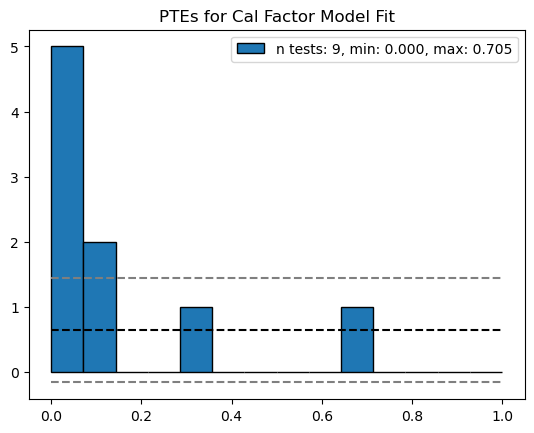

In [16]:
nbins = 14
plt.hist(pte_good_maps,bins=nbins,range=(0.0,1.0), color='tab:blue', edgecolor='black',
              label=f'n tests: {len(pte_good_maps)}, min: {np.min(pte_good_maps):.3f}, max: {np.max(pte_good_maps):.3f}')
per_bin_avg = len(pte_good_maps)/nbins
per_bin_err = np.sqrt(per_bin_avg) 
plt.hlines(per_bin_avg, 0.0, 1.0, colors='black', linestyles='dashed')
plt.hlines(per_bin_avg+per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
plt.hlines(per_bin_avg-per_bin_err, 0.0, 1.0, colors='tab:gray', linestyles='dashed')
plt.title("PTEs for Cal Factor Model Fit")
plt.legend()
plt.show()
plt.close()